# Проект: Построение модели для определения стоимости автомобилей

**Оглавление**<a id='toc0_'></a>    
- 1. [Подготовка данных](#toc1_)    
  - 1.1. [Проверка на наличие дубликатов](#toc1_1_)    
  - 1.2. [Приведение к нормативу названий столбцов, добавление описаний полей](#toc1_2_)    
  - 1.3. [Определение информативных признаков](#toc1_3_)    
  - 1.4. [Проверка уникальных значений и аномалий](#toc1_4_)    
  - 1.5. [Заполнение пропусков](#toc1_5_)    
  - 1.6. [Проверка соответствия типов данных](#toc1_6_)    
  - 1.7. [Корреляционный анализ](#toc1_7_)    
  - 1.8. [Вывод по результатам раздела 1](#toc1_8_)    
- 2. [Обучение моделей](#toc2_)    
  - 2.1. [Подготовка выборок](#toc2_1_)    
  - 2.2. [Выбор моделей](#toc2_2_)    
  - 2.3. [Линейные регрессии](#toc2_3_)    
  - 2.4. [Случайный лес](#toc2_4_)    
  - 2.5. [Градиентный бустинг](#toc2_5_)    
  - 2.6. [Вывод по результатам раздела 2](#toc2_6_)    
- 3. [Анализ моделей](#toc3_)    
  - 3.1. [Вывод по результатам раздела 3](#toc3_1_)    
- 4. [4 Общий вывод](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Задание:**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» (Заказчик) разрабатывает приложение для привлечения новых клиентов, в котором можно быстро узнать рыночную стоимость своего автомобиля. Необходимо построить модель для определения стоимости автомобиля. 

Приоритетные требования Заказчика:
- качество предсказания;
- время предсказания модели;
- время обучения модели.

Для обучения и тестирования моделей предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. 

План работы:
1. Подготовка данных.
2. Обучение моделей.
3. Анализ моделей.
4. Общий вывод.

## 1. <a id='toc1_'></a>[Подготовка данных](#toc0_)

In [154]:
!pip install category_encoders
!pip install lightgbm
!pip install phik

In [155]:
# подключение библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from lightgbm import LGBMRegressor

import re
import time
import phik
from IPython.display import display

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from category_encoders.target_encoder import TargetEncoder

# константы
RST = 12345 # значение random_state

In [156]:
# функция по переводу названий столбцов датасета в "змеиный" регистр
# на входе - датасет
def columns_to_snake(df):
    columns_new = []
    for i in range(len(df.columns)):
        columns_new.append(re.sub('(?<=[a-zA-Z])([A-Z])',('_' + '\g<1>'),df.columns[i]).lower())
    df.columns = columns_new
    return

In [157]:
# загрузка файла
try:
    data_all = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    data_all = pd.read_csv('D:\Education\Data Science\Проекты курса DS\Проект_11\datasets\\autos.csv')

# обзор данных
data_all.info()
display(pd.concat([data_all.head(5), data_all.sample(5), data_all.tail(5)]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
313280,2016-03-26 20:37:38,13900,small,2012,manual,60,up,40000,8,petrol,volkswagen,no,2016-03-26 00:00:00,0,96103,2016-04-06 12:18:03
84875,2016-03-07 15:41:33,12600,bus,2012,manual,150,other,40000,3,petrol,ford,no,2016-03-07 00:00:00,0,95704,2016-03-29 03:18:02
324124,2016-04-01 13:53:13,890,small,2003,manual,85,justy,90000,3,petrol,subaru,NaN,2016-04-01 00:00:00,0,79110,2016-04-03 10:45:02
207526,2016-03-27 23:55:55,4600,small,2006,manual,101,polo,150000,6,gasoline,volkswagen,no,2016-03-27 00:00:00,0,71522,2016-04-06 09:15:34
248434,2016-03-27 20:51:29,7499,wagon,2006,manual,140,passat,150000,2,gasoline,volkswagen,NaN,2016-03-27 00:00:00,0,6618,2016-04-03 19:45:35


Данные загружены. 354 тыс. записей - по количеству достаточно для обучения моделей.

Необходимо:  
1) Проверить на наличие дубликатов.  
2) Нормализовать названия столбцов к "змеиному" регистру, добавить описание полей.  
3) Определить и оставить только информативные признаки.  
4) Проверить уникальные значения и аномалии в данных.  
5) Заполнить пропуски.  
6) Проверить соответствие типов данных.  

<br />

### 1.1. <a id='toc1_1_'></a>[Проверка на наличие дубликатов](#toc0_)

In [158]:
# проверка на наличие дубликатов
print('Количество полных дубликатов:', data_all.duplicated().sum())
display(data_all[data_all.duplicated(keep=False)].sort_values(by='DateCrawled'))
# удаление дубликатов
data_all.drop_duplicates(inplace=True)
print('Количество полных дубликатов:', data_all.duplicated().sum())

Количество полных дубликатов: 4


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


Количество полных дубликатов: 0


Дубликаты удалены.  

<br/>

### 1.2. <a id='toc1_2_'></a>[Приведение к нормативу названий столбцов, добавление описаний полей](#toc0_)

In [159]:
# приведение названий столбцов к "змеиному" регистру
columns_to_snake(data_all)

# добавление описания столбцов
opisanie = pd.DataFrame(index=data_all.columns, columns=['Описание'], data=[
    'дата скачивания анкеты из базы',
    'цена, евро',
    'тип автомобильного кузова',
    'год регистрации автомобиля',
    'тип коробки передач',
    'мощность, л.с.',
    'модель автомобиля',
    'пробег, км.',
    'месяц регистрации автомобиля',
    'тип топлива',
    'марка автомобиля',
    'была машина в ремонте или нет',
    'дата создания анкеты',
    'количество фотографий автомобиля',
    'почтовый индекс владельца анкеты/пользователя',
    'дата последней активности пользователя'
]).rename_axis('Название столбца')
display(opisanie)

,Описание
Название столбца,
date_crawled,дата скачивания анкеты из базы
price,"цена, евро"
vehicle_type,тип автомобильного кузова
registration_year,год регистрации автомобиля
gearbox,тип коробки передач
power,"мощность, л.с."
model,модель автомобиля
kilometer,"пробег, км."
registration_month,месяц регистрации автомобиля


### 1.3. <a id='toc1_3_'></a>[Определение информативных признаков](#toc0_)

Данные нужны для построения моделей предсказания цены автомобиля. Исходя из этого условия можно не использовать в качестве признаков следующие столбцы:
- `date_crawled` (дата скачивания анкеты из базы);
- `registration_month` (месяц регистрации автомобиля);
- `date_created` (дата создания анкеты);
- `last_seen` (дата последней активности пользователя);
- `number_of_pictures` - количество фотографий автомобиля;
- `postal_code` (почтовый индекс владельца анкеты).

Удалим ненужные столбцы, сохраним результат в отдельный датасет.

In [160]:
data = data_all.drop(columns=['date_crawled', 'registration_month', 'date_created', 'last_seen', 
                              'number_of_pictures', 'postal_code'])

### 1.4. <a id='toc1_4_'></a>[Проверка уникальных значений и аномалий](#toc0_)


Статистическая информация:


,price,registration_year,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


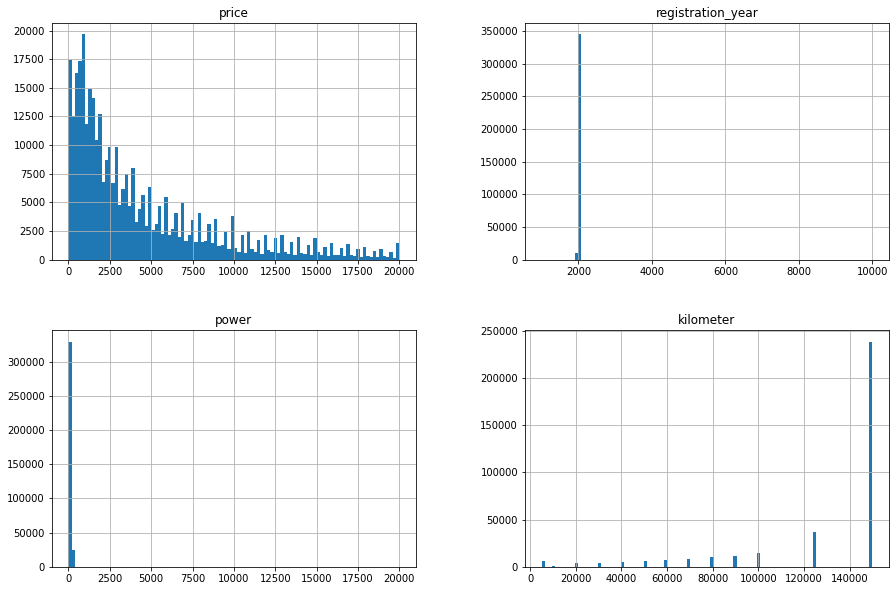

In [161]:
# отображение статистической информации для столбцов с количественными значениями
print('\nСтатистическая информация:')
display(data.describe())
data.hist(bins=100, figsize=(15,10))
plt.show()

По статистической информации и графикам видим следующие отклонения:
- Целевой признак `price` содержит нулевые и около нулевые значения.
- Год регистрации автомобиля `registration_year` содержит аномальные значения.
- Мощность двигателя `power` содержит нулевые, аномально малые и аномально большие значения.

Маловероятно, что даже подержанная машина, продаваемая на запчасти, будет стоить дешевле 300 евро (24000 руб.) Удалим строки с нулевыми значениями целевого признака `price` и значениями ниже порога в 300 евро, чтобы исключить некоррекность предсказания моделей. Отобразим результат в виде гистограммы.

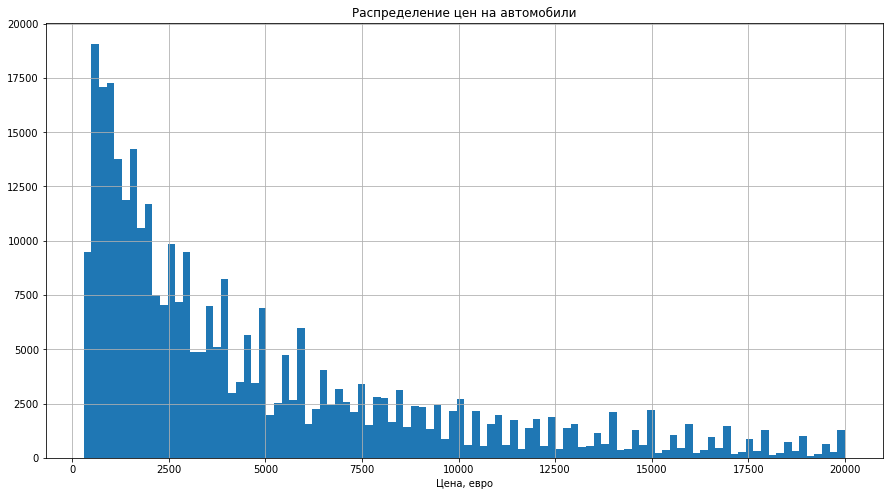

In [162]:
data = data.query('price > 300')
plt.figure(figsize=(15,8))
data['price'].hist(bins=100)
plt.title('Распределение цен на автомобили')
plt.xlabel('Цена, евро')
plt.show()

Верхнюю границу года выпуска автомобиля определим по максимальным датам создания анкеты `date_created` и последней активности пользователя `last_seen`. Нижнюю - исходя из здравого смысла установим на 1900 году (более ста с лишним лет даже антикварная машина для продажи вряд ли сохранится). Результаты также отобразим в виде гистограммы.

In [163]:
print('Максимальная дата создания анкеты:', data_all.date_created.max())
print('Максимальная дата последней активности пользователя:', data_all.last_seen.max())

Максимальная дата создания анкеты: 2016-04-07 00:00:00
Максимальная дата последней активности пользователя: 2016-04-07 14:58:51


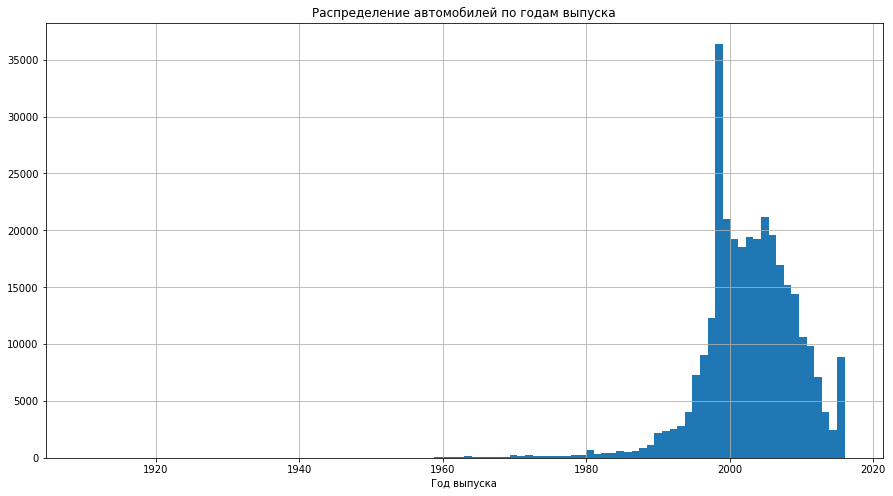

In [164]:
data = data.query('(registration_year <= 2016) & (registration_year >= 1900)')
plt.figure(figsize=(15,8))
data['registration_year'].hist(bins=100)
plt.title('Распределение автомобилей по годам выпуска')
plt.xlabel('Год выпуска')
plt.show()

Исходя из гистограммы, нижнюю границу года выпуска можно перенести на 1955 год.

In [165]:
print('Автомобилей старше 1955 года выпуска:', 
      data_all.query('(registration_year < 1955) & (price > 300)')['price'].count())
print('\t- из них с нулевой мощностью двигателя:', 
      data_all.query('(registration_year < 1955) & (power == 0) & (price > 300)')['price'].count())
print('Автомобилей старше 1980 года выпуска:', 
      data_all.query('(registration_year < 1980) & (price > 300)')['price'].count())
print('\t- из них с нулевой мощностью двигателя:', 
      data_all.query('(registration_year < 1980) & (power == 0) & (price > 300)')['price'].count())

Автомобилей старше 1955 года выпуска: 178
	- из них с нулевой мощностью двигателя: 87
Автомобилей старше 1980 года выпуска: 2998
	- из них с нулевой мощностью двигателя: 805


In [166]:
data = data.query('registration_year >= 1955')

Проанализируем автомобили с отсутствующей (нулевой) мощностью двигателя. Теоретически, это могут быть автомобили без двигателей, например, на запчасти.

Автомобилей с нулевой мощностью двигателя и ненулевой стоимостью: 36360
	- из них со стоимостью меньше 5000: 31847
	- из них со стоимостью меньше 2500: 25401


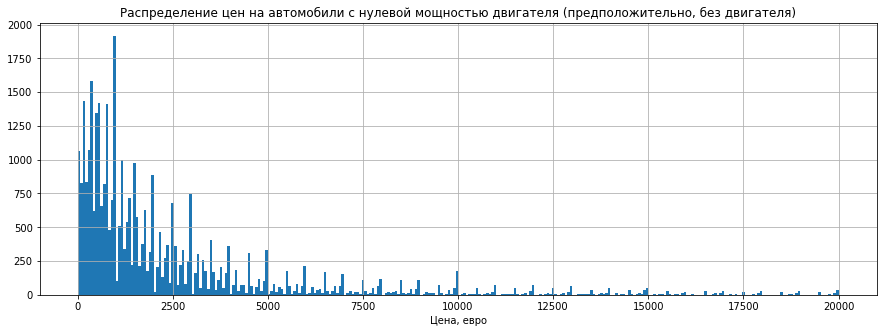

Наличие отметки о ремонте у автомобилей с нулевой мощностью двигателя и ненулевой стоимостью:
yes     4267
no     13421
NaN    18672
Name: repaired, dtype: int64


In [167]:
print('Автомобилей с нулевой мощностью двигателя и ненулевой стоимостью:', 
      data_all.query('(power == 0) & (price != 0)')['price'].count())
print('\t- из них со стоимостью меньше 5000:', 
      data_all.query('(power == 0) & (price != 0) & (price < 5000)')['price'].count())
print('\t- из них со стоимостью меньше 2500:', 
      data_all.query('(power == 0) & (price != 0) & (price < 2500)')['price'].count())

plt.figure(figsize=(15,5))
data_all.query('(power == 0) & (price != 0)')['price'].hist(bins=300)
plt.title('Распределение цен на автомобили с нулевой мощностью двигателя (предположительно, без двигателя)')
plt.xlabel('Цена, евро')
plt.show()

print('Наличие отметки о ремонте у автомобилей с нулевой мощностью двигателя и ненулевой стоимостью:',
      data_all.query('(power == 0) & (price != 0)')['repaired'].value_counts(dropna=False, ascending=True), sep='\n')

Количество автомобилей с нулевой мощностью двигателя и ненулевой стоимостью составляет порядка 36 тысяч. Это большая цифра, существенно больше 10%. Распределение цен внутри этих 36 тысяч потенциальных автомобилей без двигателя показано на графике распределения.

Как вариант, можно отбросить те автомобили, что дороже 5000 или 2500 евро, как не вполне адекватные по цене, тогда останется 31 или 25 тысяч и после этого ввести отдельный столбец-признак "без двигателя". С другой стороны, если есть автомобили без двигателя, то могут найтись и автомобили, например, без колес или без коробки передач (в этих данных тоже есть пропуски). Также надо учесть, что у 13 из этих 36 тысяч автомобилей указано, что они не были в ремонте, у 18,6 тысяч ничего не указано и только у 4,2 тысяч есть отметка о ремонте.

В связи с этим, будем считать, что нулевая мощность двигателя - это всё-таки ошибки и некорректности в данных. Косвенно это подтверждает и название сервиса: "по продаже *автомобилей с пробегом*" (не "автомобили на запчасти").

Самым мощным серийным автомобилем по состоянию на 2016г. был Koenigsegg Regera (мощность двигателя 1500 л.с.). Установим по этому значению верхнюю границу.  
Самым маломощным серийным автомобилем считается Peel P50 (мощность двигателя 4,2 л.с.). Установим по этому значению нижнюю границу.  
Результат отобразим в виде гистограммы.

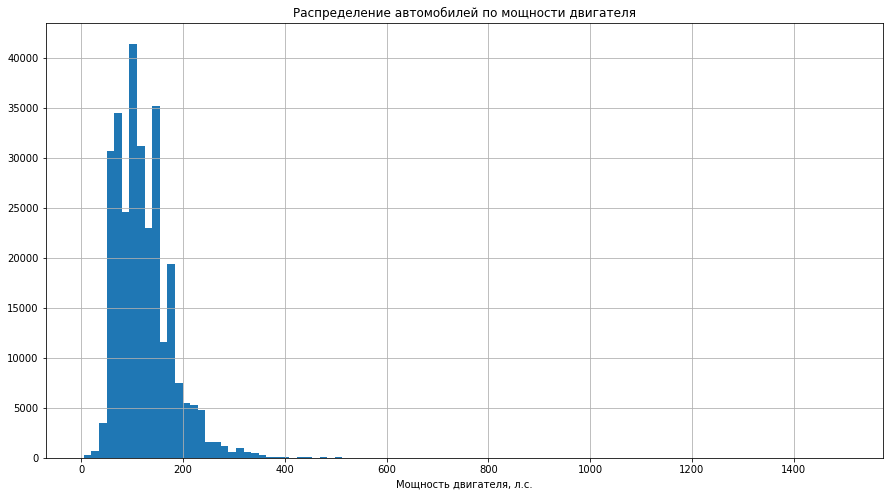

In [168]:
data = data.query('(power <= 1500) & (power > 4)')
plt.figure(figsize=(15,8))
data['power'].hist(bins=100)
plt.title('Распределение автомобилей по мощности двигателя')
plt.xlabel('Мощность двигателя, л.с.')
plt.show()

Исходя из гистограммы, верхнюю границу мощности двигателя можно установить на 500 л.с.

In [169]:
data = data.query('power <= 500')

Теперь рассмотрим и проанализируем уникальные значения в столбцах с категориальными признаками.

In [170]:
# отображение уникальных значений столбцов с категориальными значениями
for column in data.select_dtypes(include=['object']).columns:
    print('\nУникальные значения столбца "{0}" ({1}):'.format(column, opisanie.loc[column, 'Описание']))
    print(data[column].unique())


Уникальные значения столбца "vehicle_type" (тип автомобильного кузова):
['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' nan 'other']

Уникальные значения столбца "gearbox" (тип коробки передач):
['manual' 'auto' nan]

Уникальные значения столбца "model" (модель автомобиля):
[nan 'grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'other' 'civic'
 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'one' 'fortwo' '1er'
 'b_klasse' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a1' 'focus' 'a4' 'tt' 'astra'
 'a6' 'jazz' 'omega' 'polo' 'slk' '7er' 'combo' '80' '147' 'z_reihe'
 'sorento' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'insignia' 'ka'
 'almera' 'megane' 'a3' 'lupo' 'r19' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'corsa' 'vectra' 'berlingo' 'tiguan' '6_reihe' 'c4' 'panda'
 'up' 'i_reihe' 'ceed' 'kangoo' '5_reihe' 'yeti' 'octavia' 'zafira' 'mii'
 'rx_

In [171]:
print('Количество строк с значениями "other" и "sonstige_autos":', 
      data.query('(vehicle_type == "other") | (brand == "sonstige_autos") | (model == "other") | (fuel_type == "other")')
      ['price'].count())

Количество строк с значениями "other" и "sonstige_autos": 23280


В столбцах `brand`, `model`, `vehicle_type` и `fuel_type` есть значения `other` и `sonstige_autos`, которые не являются конкретными марками и моделями автомобилей, типом кузова или видом топлива. В этом случае получается, что конкретные значения неизвестны, но некоторая определенность в них присуствует - это другие названия, не те, которые указаны конкретной маркой. Не будем удалять эти значения (таких строк больше 23 тыс.). Для единообразия значение `sonstige_autos` параметра `brand` заменим на `other` и будем считать `other` одной из категорий.

In [172]:
# замена 'sonstige_autos' на 'other'
data.loc[data['brand'] == 'sonstige_autos', 'brand'] = 'other'

### 1.5. <a id='toc1_5_'></a>[Заполнение пропусков](#toc0_)

In [173]:
# выведем столбцы, имеющие пропуски данных
display(data.isna().agg('sum').sort_values(ascending=False).to_frame(name='Пропущено').query('Пропущено > 0')
        .join(round(data.isna().mean()*100, 1).sort_values(ascending=False).to_frame(name='Пропущено, %'))
        .join(opisanie))

,Пропущено,"Пропущено, %",Описание
repaired,39398,13.7,была машина в ремонте или нет
fuel_type,13822,4.8,тип топлива
model,10307,3.6,модель автомобиля
vehicle_type,9451,3.3,тип автомобильного кузова
gearbox,4818,1.7,тип коробки передач


- Пропущенные значения в столбце с признаком ремонта `repaired` заполним значением `yes`, так как с высокой вероятностью подержанная машина ремонтировалась, даже если владелец это не указывает.
- Пропущенные значения в типе коробки передач `gearbox` заполним значением `manual` - ручная. Это не исказит стоимость автомобиля.
- Достоверной информации для заполнения пропусков в данных о модели автомобиля `model`, типе автомобильного кузова `vehicle_type` и типе топлива `fuel_type` нет. Поэтому введем для этих не указанных значений дополнительную категорию `unknown`.
- У признака `fuel_type` довольно много категории, которые, на первый взгляд, могут означать одно и тоже. Рассмотрим их подробнее.  
Среди бензинового топлива: `petrol` - это бензин, `gasoline` - это американское название бензина. В газовом топливе: `lpg` - это сжиженный газ от переработки нефти (пропан-бутан), `cng` - это сжатый природный газ (метан). У них взаимозаменяемость только в одну сторону и не прямая, а через разбавление воздухом. Если `lpg` разбавить в определенных пропорциях воздухом, то после этого им можно будет заменить `cng`, в обратную сторону заменить `lpg` на `cng` нельзя. Остальные категории разные, поэтому объединять их нельзя.

In [174]:
data.fuel_type.value_counts(dropna=False)

petrol      179939
gasoline     87440
NaN          13822
lpg           4633
cng            472
hybrid         201
other           79
electric        68
Name: fuel_type, dtype: int64

In [175]:
data['repaired'].fillna(value='yes', inplace=True)
data['gearbox'].fillna(value='manual', inplace=True)
for _ in ['model', 'vehicle_type', 'fuel_type']:
    data[_].fillna(value='unknown', inplace=True)
# отображение результата замены пропусков
display(data.isna().agg('sum').sort_values(ascending=False).to_frame(name='Пропущено').query('Пропущено > 0')
        .join(round(data.isna().mean()*100, 1).sort_values(ascending=False).to_frame(name='Пропущено, %'))
        .join(opisanie))

,Пропущено,"Пропущено, %",Описание


### 1.6. <a id='toc1_6_'></a>[Проверка соответствия типов данных](#toc0_)

In [176]:
display(pd.merge(data.dtypes.rename('Тип данных').rename_axis('Название столбца'), opisanie, right_index=True, left_index=True))

,Тип данных,Описание
Название столбца,,
price,int64,"цена, евро"
vehicle_type,object,тип автомобильного кузова
registration_year,int64,год регистрации автомобиля
gearbox,object,тип коробки передач
power,int64,"мощность, л.с."
model,object,модель автомобиля
kilometer,int64,"пробег, км."
fuel_type,object,тип топлива
brand,object,марка автомобиля


В целом типы данных столбцов соответствуют содержанию. Имеет смысл столбцам с типом `object` ('vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'), установить тип `category`. Установим.

In [177]:
for _ in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']:
    data[_] = data[_].astype('category')
display(pd.merge(data.dtypes.rename('Тип данных').rename_axis('Название столбца'), opisanie, right_index=True, left_index=True))

,Тип данных,Описание
Название столбца,,
price,int64,"цена, евро"
vehicle_type,category,тип автомобильного кузова
registration_year,int64,год регистрации автомобиля
gearbox,category,тип коробки передач
power,int64,"мощность, л.с."
model,category,модель автомобиля
kilometer,int64,"пробег, км."
fuel_type,category,тип топлива
brand,category,марка автомобиля


### 1.7. <a id='toc1_7_'></a>[Корреляционный анализ](#toc0_)

Построим и проанализируем диаграммы рассеяния.

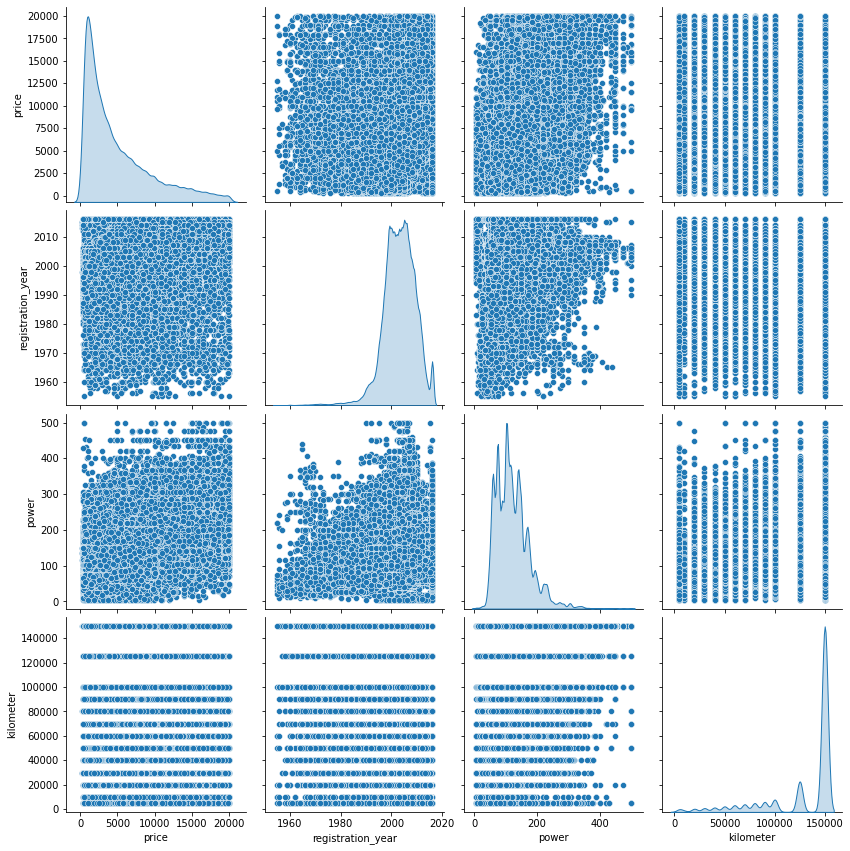

In [178]:
sns.pairplot(data, diag_kind='kde', height=3)
plt.show()

Параметры (в частности цена и пробег) имеют форму распределения не совпадающую с нормальным. Кроме того, у параметра пробег в распределении наблюдается некоторая дискретность. В такой ситуации для определения корреляции нужно использовать критерий Спирмена или Phik. Рассчитаем и построим оба.

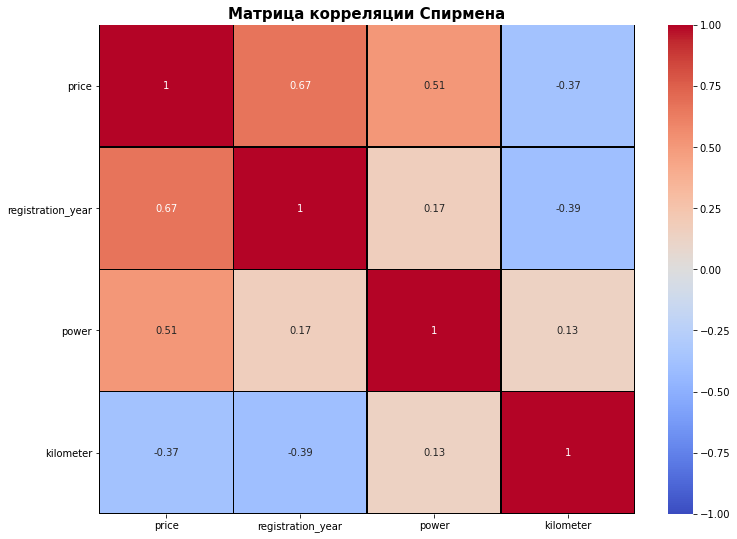

In [179]:
# построение матрицы корреляции Спирмена
plt.figure(figsize=(12, 9))
sns.heatmap(data.corr(method='spearman'), vmin=-1, vmax=+1, cmap='coolwarm', annot=True, linewidths=.1, linecolor='black')
plt.yticks(rotation=0)
plt.title('Матрица корреляции Спирмена', size=15, fontweight='bold')
plt.show()

Матрица с коэффициентами корреляции Phik


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.000000,0.262929,0.656892,0.325551,0.511551,0.570811,0.318410,0.251042,0.351040,0.341420
vehicle_type,0.262929,1.000000,0.256059,0.215085,0.453202,0.902127,0.258085,0.392425,0.592902,0.177701
registration_year,0.656892,0.256059,1.000000,0.108467,0.280191,0.626220,0.395634,0.255816,0.379123,0.195507
gearbox,0.325551,0.215085,0.108467,1.000000,0.586331,0.625368,0.027350,0.212445,0.506603,0.049619
power,0.511551,0.453202,0.280191,0.586331,1.000000,0.781399,0.096128,0.242780,0.572508,0.090516
model,0.570811,0.902127,0.626220,0.625368,0.781399,1.000000,0.447885,0.543424,0.998001,0.191162
kilometer,0.318410,0.258085,0.395634,0.027350,0.096128,0.447885,1.000000,0.160085,0.277080,0.132812
fuel_type,0.251042,0.392425,0.255816,0.212445,0.242780,0.543424,0.160085,1.000000,0.329988,0.204619
brand,0.351040,0.592902,0.379123,0.506603,0.572508,0.998001,0.277080,0.329988,1.000000,0.079903
repaired,0.341420,0.177701,0.195507,0.049619,0.090516,0.191162,0.132812,0.204619,0.079903,1.000000


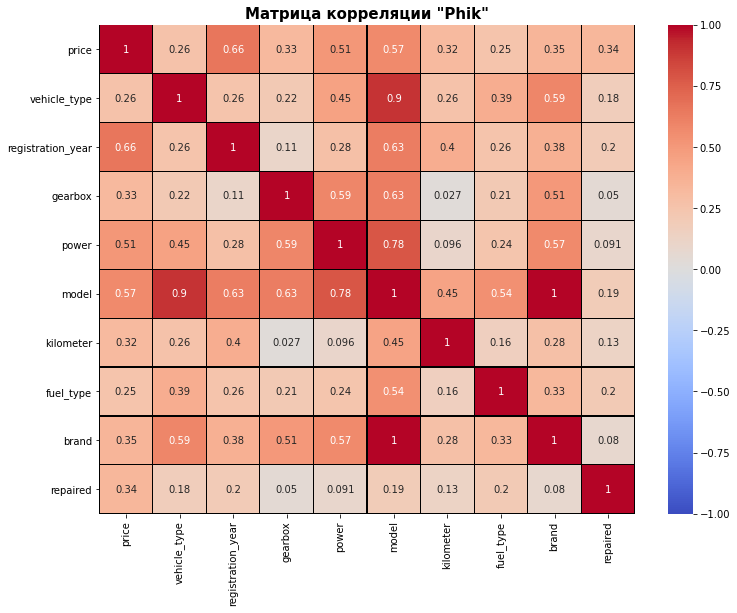

In [192]:
# построение матрицы с коэффициентом корреляции Phik
data_phik = data.phik_matrix(interval_cols=list(data.select_dtypes(include='int64').columns))
print('Матрица с коэффициентами корреляции Phik')
display(data_phik)

plt.figure(figsize=(12, 9))
sns.heatmap(data_phik, vmin = -1, vmax = +1, cmap = 'coolwarm', annot=True, linewidths=.1, linecolor='black')
plt.yticks(rotation=0)
plt.title('Матрица корреляции "Phik"', size=15, fontweight='bold')
plt.show()

Сильной корреляции между параметрами нет.
- Наибольшая прямая зависимость наблюдается между годом выпуска автомобиля и его стоимостью (чем более новый автомобиль, тем он дороже).
- В меньшей степени есть прямая зависимость между мощностью двигателя автомобиля и его ценой (чем больше мощность, тем дороже автомобиль).
- Обратная зависимость есть между пробегом автомобиля и его годом выпуска и ценой (чем больше пробег, тем раньше год выпуска автомобиля и меньше цена).

### 1.8. <a id='toc1_8_'></a>[Вывод по результатам раздела 1](#toc0_)

Объем загруженных данных (354 тыс. записей) достаточен для построения моделей. Нормализованы названия столбцов, добавлено описание полей данных.

В рамках общей подготовки данных:
- Обнаруженны и удалены дубликаты.
- Проверена корректность типов данных. Для категориальных признаков установлен тип `category`.
- Определены и вынесены в отдельный датасет для дальнейшей работы информативные признаки для обучения моделей.
- Проведена проверка уникальных и аномальных значений. В столбцах `brand`, `model`, `vehicle_type` и `fuel_type` сохранена категория `other`. Обнаруженные аномальные значения удалены. Для обработки аномальных значений применен метод удаления аномалий по следующим причинам:
    - аномальные значения с высокой вероятностью являются полностью случайными;
    - достаточно большое количество записей позволяет использовать метод удаления без влияния на обучение моделей;
    - удаление аномальных значений не приведет к искажению данных, в то время как замена аномальных значений, даже многомерными методами, искажения внесет;
    - в приложение по определению стоимости автомобиля, которое разрабатывает Заказчик и для которого строится модель, будет встроена защита от ввода некорректных значений.
- Заполнены пропуски в категориальных признаках. Для обработки пропусков применен метод заполнения наиболее вероятным константным значением и создание отдельной категории. В результате выполнены следующие преобразования:
    - пропущенные значения признака ремонта (`repaired`) заполнены значением `yes`;
    - пропущенные значения типе коробки передач (`gearbox`) заполнены значением `manual`;
    - для пропущенных значений в информации о модели автомобиля (`model`), типе автомобильного кузова (`vehicle_type`) и типе топлива (`fuel_type`) введена дополнительная категория `unknown`.

Корреляционный анализ показал среднюю по силе корреляцию между следующими признаками:
- прямая зависимость между годом выпуска автомобиля и его стоимостью;
- прямая зависимость между мощностью двигателя автомобиля и его ценой;
- обратная зависимость между пробегом автомобиля и его годом выпуска и ценой.

Методы, использованные для предобработки, не создают утечки данных между тестовой и обучающей выборками и должны быть идентично применены к обоим выборкам. В связи с этим разделение на обучающую и тестовую выборки можно провести после этапа предобработки данных.

## 2. <a id='toc2_'></a>[Обучение моделей](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Подготовка выборок](#toc0_)

При обучении всех моделей будем использовать кроссвалидацию, поэтому достаточно разделить данные на обучающую и тестовую выборки. Размер тестовой выборки установим 20%.

In [24]:
features = data.drop('price', axis=1)
target = data['price']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state=RST)

print(f'''
Обучающая выборка (features_train, target_train):
    - признаки {features_train.shape};
    - целевой признак ({target_train.shape[0]}).
Тестовая выборка (features_test, target_test):
    - признаки {features_test.shape};
    - целевой признак ({target_test.shape[0]}).
''')


Обучающая выборка (features_train, target_train):
    - признаки (229323, 9);
    - целевой признак (229323).
Тестовая выборка (features_test, target_test):
    - признаки (57331, 9);
    - целевой признак (57331).



### 2.2. <a id='toc2_2_'></a>[Выбор моделей](#toc0_)

В рамках задания установлены приоритетные требования по качеству и скорости предсказаний, а также времени обучения. Выберем модели разных классов, проведем их обучение и сравним результаты, измеряя качество предсказаний и время обучения.

Целевой признак количественный, будем изучать и анализировать следующие модели:
- Линейные регрессии. Простая модель линейной регрессии для быстрой оценки ситуации (`LinearRegression`) и улучшенная линейная регрессия с L2 регуляризацией (`Ridge`), позволяющая уменьшить вероятность переобучения и более устойчивая к мультиколлинеарности.
- Случайный лес (`RandomForestRegressor`). Это ансамбль из моделей типа решающее дерево (`DecisionTreeRegressor`) в котором результаты отдельных деревьев усредняются, что позволяет снизить дисперсию и при этом оставаться устойчивым к переобучению.
- Градиентный бустинг (`LightGBM`). Это также ансамбль из простых моделей типа решающее дерево в котором каждая последующая базовая модель учитывает ошибку предудущей, тем самым минимизируется ошибка ансамбля. Градиентный бустинг `LightGBM` в отличии от других моделей градиентного бустинга строит несимметричные деревья ориентируясь на бОльшую величину градиента и имеет более высокую скорость обучения, сохряняя при этом высокую точность.

Масштабирование количественных признаков будем осуществлять с помощью `StandardScaler`. Кодирование категориальных признаков с помощью `TargetEncoder`, так как техника прямого кодирования (`OneHotEncoder`) в ходе преобразования утяжеляет выборку дополнительными признаками, что приемлемо для линейных моделей, но усложняет работу моделей случайного леса и градиентного бустинга, а техника порядкового кодирования (`OrdinalEncoder`) не подходит для линейных моделей и при замене категорий порядковыми номерами создает дополнительные несуществующие в изначальных данных зависимости. Для наших данных это критично, так как, например, признак `model` имеет 250 категорий.

Подбор гиперпараметров осуществим с помощью `GridSearchCV` и кросс-валидации. Для создания сквозного процесса используем пайплайн (`Pipeline`).

В качестве метрики будем использовать RMSE, результирующее значение которой не должно превышать 2500.

Для обучения моделей, подбора гиперпараметров, измерения RMSE и времени обучения создадим пользовательскую функцию `model_fit`.

In [25]:
# функция обучения модели
# на входе: созданная модель, выборки признаков и целевого признака,
# гиперпараметры для подбора и количество итераций кроссвалидации
# на выходе: обученная модель, её лучший RMSE и параметры, время обучения
def model_fit(model_type, features, target, param_grid, cv):
    # засекаем время
    start_time = time.time()
    # подготовка масштабирования и кодирования
    transformer = ColumnTransformer([
        ('num', StandardScaler(), make_column_selector(dtype_include='int64')),
        ('cat', TargetEncoder(), make_column_selector(dtype_include='category'))
        ])
    # создание пайплайн
    pipe = Pipeline([
        ('transformer', transformer),
        ('regressor', model_type)
        ])
    # подбор гиперпараметров с использованием кросс-валидации
    model = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
    model.fit(features, target)
    rmse = -model.best_score_
    param = model.best_params_
    # подсчет времени выполнения
    time_fit = time.time() - start_time
    # вывод результатов
    print(f'''
Лучшие гиперпараметры:{pd.DataFrame.from_dict(param, orient='index').rename(columns={0:''})}
RMSE: {rmse:0.0f}
Время обучения: {time_fit:0.1f} сек. ({time.strftime("%H:%M:%S", time.gmtime(time_fit))})''')
    return model, rmse, param, time_fit

### 2.3. <a id='toc2_3_'></a>[Линейные регрессии](#toc0_)

Для модели простой линейной регрессии практически нет гиперпараметров для подбора. Выполним с помощью подготовленной пользовательской функции `model_fit` масштабирование численных и кодирование категориальных признаков, обучим с применением кроссвалидации, измерим метрику RMSE и время обучения.

In [26]:
print('Модель "линейная регрессия"')
# гиперпараметр для подбора
param_grid = [{
    'regressor__fit_intercept': [True, False]
    }]

lg_mod, lg_rmse, lg_param, lg_time_fit = model_fit(LinearRegression(), features_train, target_train, param_grid, 5)

Модель "линейная регрессия"
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Лучшие гиперпараметры:                              
regressor__fit_intercept  True
RMSE: 2760
Время обучения: 12.1 сек. (00:00:12)


Аналогично рассмотрим улучшенную линейную регрессию с L2 регуляризацией. В качестве гиперпараметров для подбора возьмем коэффициент регуляризации (`alpha`) и тип обработки (`solve`).

In [27]:
print('Модель "линейная регрессия с L2 регуляризацией"')
# гиперпараметры и их диапазоны для подбора
param_grid = [{
    'regressor__alpha': range(0, 500, 100),
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr']
    }]

rid_mod, rid_rmse, rid_param, rid_time_fit = model_fit(Ridge(random_state=RST), features_train, target_train, param_grid, 5)

Модель "линейная регрессия с L2 регуляризацией"
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Лучшие гиперпараметры:                       
regressor__alpha      0
regressor__solver  auto
RMSE: 2760
Время обучения: 120.0 сек. (00:02:00)


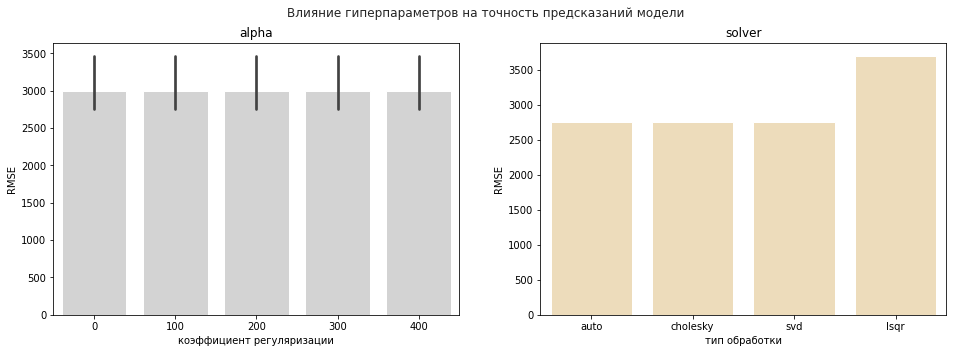

In [28]:
# построение графиков влияния подбираемых гиперпараметров на модель
res_rid = pd.DataFrame(rid_mod.cv_results_).sort_values(by='rank_test_score')
res_rid.mean_test_score = - res_rid.mean_test_score
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.set_style("whitegrid")
fig.suptitle('Влияние гиперпараметров на точность предсказаний модели')
sns.barplot(x='param_regressor__alpha', y='mean_test_score', data=res_rid, ax=axes[0], color='lightgrey')
axes[0].set (xlabel='коэффициент регуляризации', ylabel='RMSE')
axes[0].set_title(label = 'alpha')
sns.barplot(x='param_regressor__solver', y='mean_test_score', data=res_rid, ax=axes[1], color='wheat')
axes[1].set (xlabel='тип обработки', ylabel='RMSE')
axes[1].set_title(label = 'solver')
plt.show()

Видим, что значение коэффициента регуляризации (`alpha`) не влияет на изменение точности. Можно сказать, что на этих данных линейная регрессия с L2 регуляризацией отрабатывает как простая линейная регрессия. Зависимость точности модели от выбора типа обработки (`solve`) есть, в то же время можно отметить, что автоматический выбор данного параметра, установленный по умолчанию, отрабатывает на уровне лучших значений, поэтому можно не заниматься подбором данного гиперпараметра.

Модели линейной регрессии обучаются быстро, в том числе за счет того, что не требуют подбора гиперпараметров, но точность предсказаний низкая, требование по точности предсказаний (RMSE < 2500) не обеспечивается.

### 2.4. <a id='toc2_4_'></a>[Случайный лес](#toc0_)

Для сокращения времени обучения модели ограничимся подбором двух, оказывающих основное влияние на результат модели, гиперпараметров: количество деревьев (`n_estimators`) и глубина дерева (`max_depth`).

Гиперпараметру количество признаков (`max_features`) установим значение, рекомендованное для задач классификации - `sqrt`, а гипарпараметрам `min_samples_leaf` и `min_samples_split` оставим значения по умолчанию. В такой комбинации гиперпараметров модель выдает лучшие результаты.  
(Влияние этих гиперпараметров рассматривалось отдельно, указанные значения давали лучшую точность модели, строки этого исследования в коде закомментированы.)

In [29]:
print('Модель "случайный лес"')
# гиперпараметры и их диапазоны для подбора
param_grid = [{
    'regressor__n_estimators': [10, 50, 100, 200],
    'regressor__max_depth': [8, 15, 20, 25],
#    'regressor__max_features': ['log2', 'sqrt', 1],
#    'regressor__min_samples_leaf': [2, 4, 8],
#    'regressor__min_samples_split': [2, 4, 8]
    }]

rfr_mod, rfr_rmse, rfr_param, rfr_time_fit = model_fit(RandomForestRegressor(max_features='sqrt', random_state=RST), 
                                                       features_train, target_train, param_grid, 5)

Модель "случайный лес"
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Лучшие гиперпараметры:                            
regressor__max_depth      20
regressor__n_estimators  200
RMSE: 1530
Время обучения: 1144.1 сек. (00:19:04)


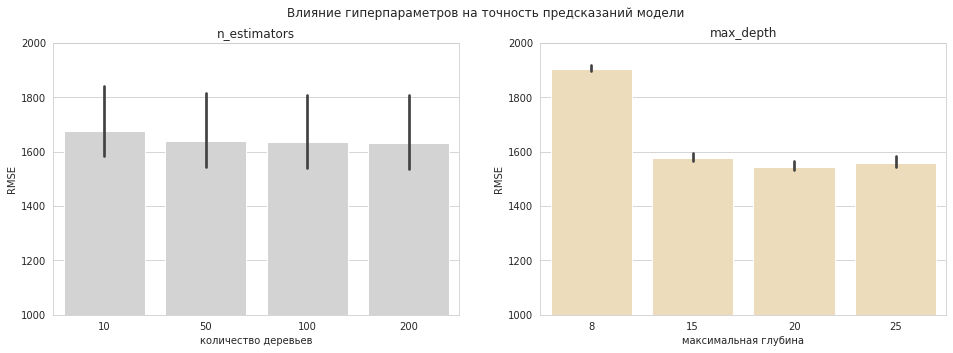

In [30]:
# построение графиков влияния подбираемых гиперпараметров на модель
res_rs = pd.DataFrame(rfr_mod.cv_results_).sort_values(by='rank_test_score')
res_rs.mean_test_score = - res_rs.mean_test_score
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.set_style("whitegrid")
fig.suptitle('Влияние гиперпараметров на точность предсказаний модели')
sns.barplot(x='param_regressor__n_estimators', y='mean_test_score', data=res_rs, ax=axes[0], color='lightgrey')
axes[0].set (xlabel='количество деревьев', ylabel='RMSE')
axes[0].set_ylim([1000, 2000])
axes[0].set_title(label = 'n_estimators')
sns.barplot(x='param_regressor__max_depth', y='mean_test_score', data=res_rs, ax=axes[1], color='wheat')
axes[1].set (xlabel='максимальная глубина', ylabel='RMSE')
axes[1].set_ylim([1000, 2000])
axes[1].set_title(label = 'max_depth')
plt.show()

Видим, что влияние параметра количество деревьев (`n_estimators`) после значений 50 - 100 на модель слабое. Дальнейшее увеличение количества деревьев не целесообразно. В случае необходимости сокращения времени обучения модели, можно без особого ущерба для точности предсказаний ограничить количество деревьев до 100 или даже 50.

Влияние параметра максимальной глубины дерева (`max_depth`) на точность показаний сильная и увеличивается по мере увеличения глубины. На уровне 20 достигает насыщения, дальнейшее увеличение грубины дерева нецелесообразно.

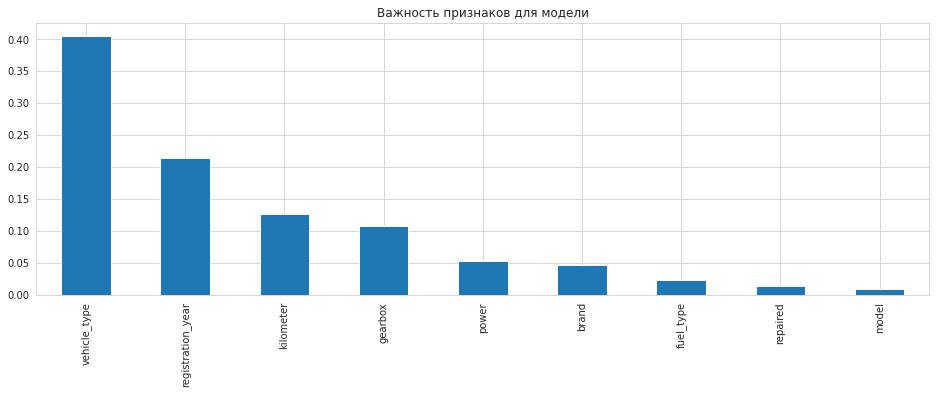

In [31]:
# построение графика важности признаков для модели
pd.Series(rfr_mod.best_estimator_.named_steps['regressor'].feature_importances_, features_train.columns
         ).sort_values(ascending=False).plot(kind='bar', figsize=(16,5), title='Важность признаков для модели')
plt.show()

Видим, что модель определила самым важным признаком тип кузова автомобиля (`vehicle_type`). В целом это закономерно, так как тип кузова определяет в целом, что это за автомобиль: легковая, внедорожник или автобус, соответственно, от вида автомобиля зависит и его цена. Далее в ТОП-3 по важности закономерно входят год регистрации (`registration_year`) и пробег автомобиля (`kilometer`).

### 2.5. <a id='toc2_5_'></a>[Градиентный бустинг](#toc0_)

Для сокращения времени обучения модели и установления сопоставимых условий с моделью случайный лес ограничимся подбором трех, оказывающих основное влияние на результат модели, гиперпараметров: количество деревьев (`n_estimators`), количество листьев в дереве (`num_leaves`) и скорость обучения (`learning_rate`).

Гиперпараметрам глубина дерева (`max_depth`) и тип алгоритма (`boosting_type`) установим значения по умолчанию, которые дают лучший результат по точности модели.  
(Влияние этих гиперпараметров рассматривалось отдельно, значения по умолчанию давали лучший результат, строки этого исследования в коде закомментированы. Гиперпараметр `max_depth` при изменении от `5` до `15` улучшает точность модели, при этом доходит до насыщения и почти выводит точность модели на уровень, как при значении по умолчанию `-1`. Гиперпараметр `boosting_type` при значениях `gbdt` и `goss` показывает похожие значения точности модели, при значении `dart` точность существенно ухудшается и возрастает время обучения.)

In [32]:
print('Модель "градиентный бустинг"')
# гиперпараметры и их диапазоны для подбора
param_grid = [{
    'regressor__n_estimators': [100, 300, 400],
#    'regressor__max_depth': [-1, 5, 10, 15],
    'regressor__num_leaves': [31, 100, 200],
    'regressor__learning_rate': [.1, .5],
#    'regressor__boosting_type': ['gbdt', 'dart', 'goss']
    }]

lgbmr_mod, lgbmr_rmse, lgbmr_param, lgbmr_time_fit = model_fit(LGBMRegressor(random_state=RST, num_threads=1, n_jobs=None), 
                                                       features_train, target_train, param_grid, 5)

Модель "градиентный бустинг"
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Лучшие гиперпараметры:                               
regressor__learning_rate    0.1
regressor__n_estimators   400.0
regressor__num_leaves     200.0
RMSE: 1518
Время обучения: 394.5 сек. (00:06:34)


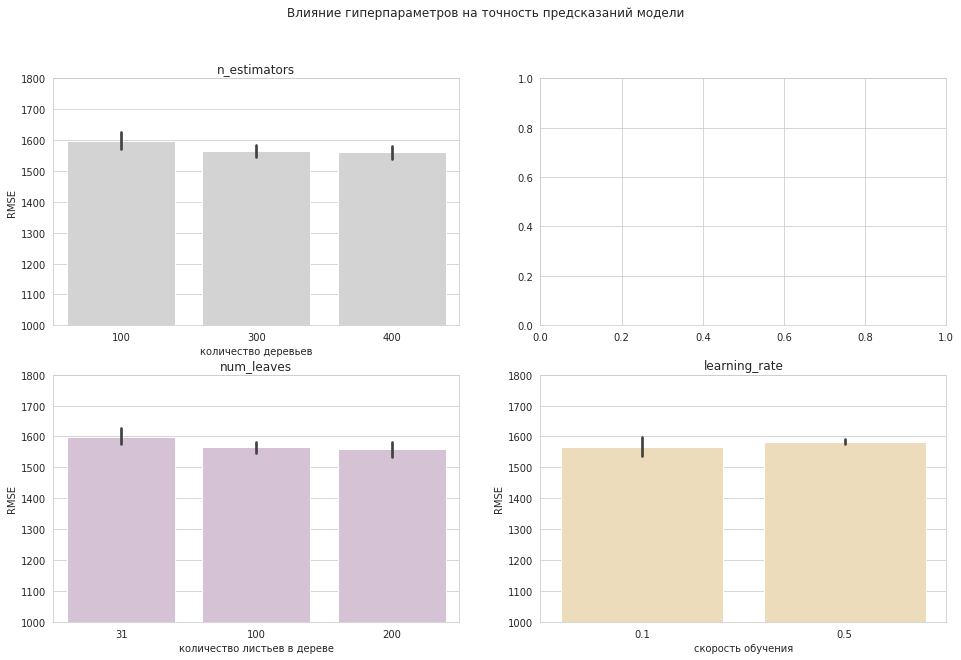

In [33]:
# построение графиков влияния подбираемых гиперпараметров на модель
res_lgbmr = pd.DataFrame(lgbmr_mod.cv_results_).sort_values(by='rank_test_score')
res_lgbmr.mean_test_score = - res_lgbmr.mean_test_score
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.set_style("whitegrid")
fig.suptitle('Влияние гиперпараметров на точность предсказаний модели')
sns.barplot(x='param_regressor__n_estimators', y='mean_test_score', data=res_lgbmr, ax=axes[0,0], color='lightgrey')
axes[0,0].set (xlabel='количество деревьев', ylabel='RMSE')
axes[0,0].set_ylim([1000, 1800])
axes[0,0].set_title(label = 'n_estimators')
#sns.barplot(x='param_regressor__max_depth', y='mean_test_score', data=res_lgbmr, ax=axes[0,1], color='lightblue')
#axes[0,1].set (xlabel='максимальная глубина дерева', ylabel='RMSE')
#axes[0,1].set_ylim([1000, 1800])
#axes[0,1].set_title(label = 'max_depth')
sns.barplot(x='param_regressor__num_leaves', y='mean_test_score', data=res_lgbmr, ax=axes[1,0], color='thistle')
axes[1,0].set (xlabel='количество листьев в дереве', ylabel='RMSE')
axes[1,0].set_ylim([1000, 1800])
axes[1,0].set_title(label = 'num_leaves')
sns.barplot(x='param_regressor__learning_rate', y='mean_test_score', data=res_lgbmr, ax=axes[1,1], color='wheat')
axes[1,1].set (xlabel='скорость обучения', ylabel='RMSE')
axes[1,1].set_ylim([1000, 1800])
axes[1,1].set_title(label = 'learning_rate')
#sns.barplot(x='param_regressor__boosting_type', y='mean_test_score', data=res_lgbmr, ax=axes[1,1], color='moccasin')
#axes[1,1].set (xlabel='тип алгоритма', ylabel='RMSE')
#axes[1,1].set_ylim([1000, 1800])
#axes[1,1].set_title(label = 'boosting_type')
plt.show()

Увеличение гиперпараметра (`n_estimators`) улучшает точность модели. Насыщение наступает на уровне 300 - 400, после чего дальнейшее увеличение данного параметра нецелесообразно.

Увеличение гиперпараметра (`num_leaves`) также улучшает точность модели.  Насыщение наступает на уровне 200, после чего дальнейшее увеличение данного параметра нецелесообразно.

Гиперпараметр скорость обучения (`learning_rate`) показал лучшую точность модели на своем значении по умолчанию 0,1.  
(отдельно проведенные расширенные изучения данного параметра показывают, что точность модели ухудшается как при меньшении данного параметра до 0,01, так и при увеличении его до 1)

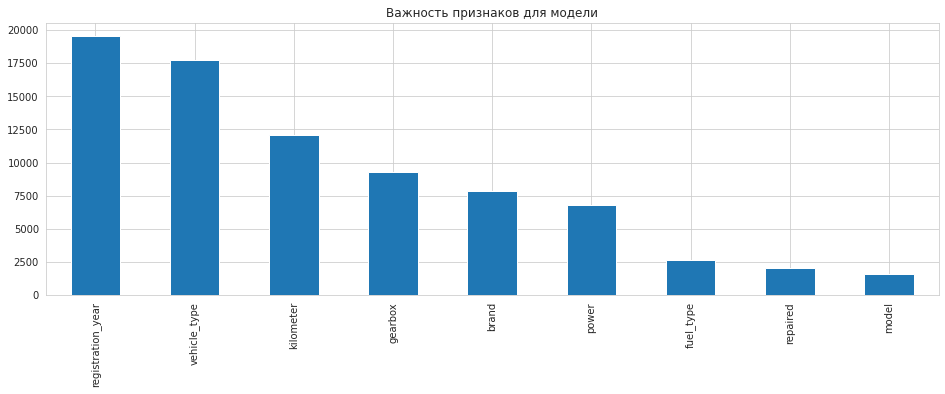

In [34]:
# построение графика важности признаков для модели
pd.Series(lgbmr_mod.best_estimator_.named_steps['regressor'].feature_importances_, features_train.columns
         ).sort_values(ascending=False).plot(kind='bar', figsize=(16,5), title='Важность признаков для модели')
plt.show()

В ТОП-3 по важности признаков для модели, также как у модели случайный лес, вошли: год регистрации автомобиля (`registration_year`), тип кузова (`vehicle_type`) и пробег (`kilometer`).

### 2.6. <a id='toc2_6_'></a>[Вывод по результатам раздела 2](#toc0_)

Рассмотрев три вида моделей можно сделать следующие выводы:
- линейные регрессии очень быстро отрабатывают по стравнению с другими типами тоделей, но имеют худшую точность, не укладывающуюся в требование по точности предсказаний (RMSE < 2500).
- Случайный лес и градиентный бустинг имеют схожую, гораздо более высокую точность, чем линейные регрессии. Требование по точности предсказаний (RMSE < 2500) выполняется. При этом обучение моделей занимает в разы больше времени.
- Из двух моделей случайный лес и градиентный бустинг при схожей точности и примерно одинаковом количестве вариантов подбираемых гиперпараметров, последняя имеет более высокую скорость обучения.

## 3. <a id='toc3_'></a>[Анализ моделей](#toc0_)

Проведем измерения времени предсказания каждой из моделей для двух случаев:
- время предсказания для всех записей обучающей выборки;
- среднее время предсказания для одной записи из обучающей выборки.

Создадим пользовательскую функцию.

In [35]:
# функция определения времени предсказания модели для выборки
# и среднего времени одного предсказания (считается как среднее для 1000 случайно выбранных записей) 
def time_pred(model):
    # определение времени предсказания для всей выборки
    start_time = time.time()
    model.predict(features_train)
    time_pred_all = time.time() - start_time
    print(f'Время предсказания для обучающей выборки {time_pred_all:0.2f} сек.')
    # определение времени одного предсказания
    np.random.seed(RST)
    numb = np.random.randint(0, features_train.shape[0], size=1000)
    times = []
    for i in numb:
        start_time = time.time()
        model.predict(features_train.iloc[[i]])
        times.append(time.time() - start_time)
    time_pred_one = np.mean(times) * 1000
    print(f'Среднее время одного предсказания {time_pred_one:0.2f} мс.\n')
    return time_pred_all, time_pred_one

In [36]:
print('Линейная регрессия:')
lg_time_pred, lg_time_pred_one = time_pred(lg_mod)
print('Линейная регрессия с L2 регуляризацией:')
rid_time_pred, rid_time_pred_one = time_pred(rid_mod)
print('Случайный лес:')
rfr_time_pred, rfr_time_pred_one = time_pred(rfr_mod)
print('Градиентный бустинг:')
lgbmr_time_pred, lgbmr_time_pred_one = time_pred(lgbmr_mod)

Линейная регрессия:
Время предсказания для обучающей выборки 0.26 сек.
Среднее время одного предсказания 13.03 мс.

Линейная регрессия с L2 регуляризацией:
Время предсказания для обучающей выборки 0.24 сек.
Среднее время одного предсказания 12.92 мс.

Случайный лес:
Время предсказания для обучающей выборки 13.19 сек.
Среднее время одного предсказания 24.23 мс.

Градиентный бустинг:
Время предсказания для обучающей выборки 9.59 сек.
Среднее время одного предсказания 13.22 мс.



Соберем все результаты в таблицу.

In [37]:
models = pd.DataFrame(data=[
        [lg_time_fit, lg_rmse, lg_time_pred, lg_time_pred_one],
        [rid_time_fit, rid_rmse, rid_time_pred, rid_time_pred_one],
        [rfr_time_fit, rfr_rmse, rfr_time_pred, rfr_time_pred_one],
        [lgbmr_time_fit, lgbmr_rmse, lgbmr_time_pred, lgbmr_time_pred_one]],
         index=['линейная регрессия (LinearRegression)','линейная регрессия с L2 регуляризацией (Ridge)',
                'случайный лес (RandomForestRegressor)', 'градиентный бустинг (LGBMRegressor)'],
         columns=['время обучения, сек.', 'качество предсказания (RMSE)', 'время предсказания, сек.',
                  'время одного предсказания, мс.']).round(2)
display(models)

,"время обучения, сек.",качество предсказания (RMSE),"время предсказания, сек.","время одного предсказания, мс."
линейная регрессия (LinearRegression),12.14,2760.44,0.26,13.03
линейная регрессия с L2 регуляризацией (Ridge),120.05,2760.44,0.24,12.92
случайный лес (RandomForestRegressor),1144.09,1529.50,13.19,24.23
градиентный бустинг (LGBMRegressor),394.54,1518.42,9.59,13.22


Обе модели линейной регрессии имея высокую скорость обучения, при этом сильно отстают по качеству предсказаний и не укладываются в норматив RMSE < 2500, поэтому не подходят.

Модели случайный лес и градиентный бустинг близки по качеству предсказаний. Этот показатель у них значительно лучше и укладывается в норматив по RMSE. При этом по всем временным показателям градиентный бустинг опережает случайный лес, особенно по времени обучения.

В результате, наиболее подходящей под требования Заказчика моделью является градиентный бустинг.

Проверим качество предсказаний лучшей модели на тестовой выборке с помощью метрики RMSE.

In [38]:
print(f'RMSE на тестовой выборке: {mean_squared_error(target_test, lgbmr_mod.predict(features_test), squared=False):0.0f}')

RMSE на тестовой выборке: 1528


Значение RMSE на тестовой выборке укладывается в норматив и близко к значению на обучающей.

### 3.1. <a id='toc3_1_'></a>[Вывод по результатам раздела 3](#toc0_)

Рассмотрено четыре модели трех разных типов:
- линейная регрессия;
- случайный лес;
- градиентный бустинг.

Все модели обучались на одинаково подготовленной выборке, для всех был осуществлен подбор наиболее влияющих на качество предсказаний гиперпараметров. В процессе работы для каждой модели проведены расчет метрики RMSE и измерения времени на этапе обучения и предсказания.

По совокупности факторов наиболее соответствующей требованиям Заказчика является модель градиентного бустинга. Данная модель была проверена на тестовой выборке, где показала хорошее качество предсказаний, аналогичное предсказаниям на обучающей/валидационной выборке.

## 4. <a id='toc4_'></a>[4 Общий вывод](#toc0_)

В ходе реализации проекта были получены и успешно загружены исходные данные, их количество достаточно для построения моделей. В рамках этапа предобработки данных проведены следующие мероприятия:
- нормализованы названия столбцов, добавлены описание полей;
- обнаруженны и удалены дубликаты;
- установлены корректные типы данных;
- заполнены пропуски;
- проанализированы уникальные и аномальные значения;
- определены информативные признаки для обучения моделей;
- выполнено разделение исходных данных на обучающую/валидационную и тестовую выборки.

Проведенный корреляционный анализ показал логически ожидаемую, среднюю по силе корреляцию между некоторыми признаками.

Для обучения выбраны модели трех разных типов: линейная регрессия, случайный лес и градиентный бустинг. Для обучения использована типовая схема обучения, реализованная в виде пользовательской функции и состоящая из следующих этапов:
- предварительная трансформация с применением `ColumnTransformer`, содержащая:
    - масштабирование количественных признаков с помощью `StandardScaler`;
    - кодирование категориальных признаков с помощью `TargetEncoder`;
- подбор гиперпараметров на базе `GridSearchCV`, включающий кросс-валидацию и расчет метрики RMSE;
- сквозной процесс между этапами организован с помощью `Pipeline`.

По результатам анализа и тестирования моделей можно сделать следующие выводы:
- Модели линейной регрессии быстры, но не обеспечивают необходимую точность и качество предсказаний. Для выполнения установленных требований не подходят.
- Модель случайный лес имеет хорошее качество предсказаний и низкую скорость обучения. По времени предсказания модель также показывает худший результат, но в абсолютных значениях предсказания занимают относительно небольшое время. Данную модель можно рекомендовать для задач, требующих хорошего качества предсказаний и не критичных ко времени выполнения.
- Модель градиентный бустинг показала лучшее качество предсказаний по метрике RMSE, обогнав, пусть и незначительно, по этому показателю модель случайный лес. Время обучения модели дольше, чем у моделей линейной регрессии, но при этом практически в три раза быстрее, чем у модели случайный лес. В части времени предсказаний по всей выборке модель занимает среднее место, в части единичных предсказаний сопоставима с быстрыми моделями линейной регрессии.

В качестве результата исследования, для реализации проекта Заказчика рекомендуется использовать модель градиентный бустинг, как наиболее соответствующую поставленным требованиям. На тестовой выборке модель показала хорошее качество предсказаний, сопоставимое с предсказаниями на обучающей/валидационной выборке.